In [35]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize


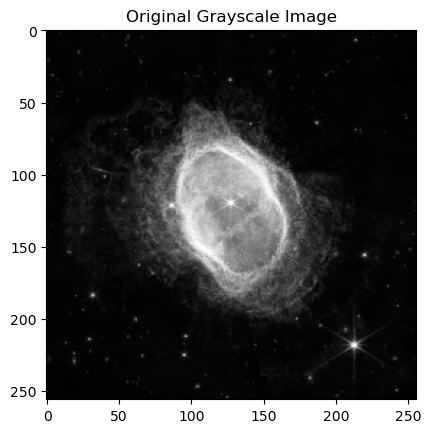

In [36]:
img_url = 'https://c4.wallpaperflare.com/wallpaper/757/318/501/nasa-universe-james-webb-space-telescope-hd-wallpaper-preview.jpg'
image_rgb = io.imread(img_url)
image_gray = color.rgb2gray(image_rgb)

image_gray = resize(image_gray, (256, 256), anti_aliasing=True)

plt.imshow(image_gray, cmap='gray')
plt.title('Original Grayscale Image')
plt.show()


In [37]:
U, S, VT = np.linalg.svd(image_gray, full_matrices=False)


In [38]:
def reconstruct_image(U, S, VT, k):
    S_k = np.diag(S[:k])
    U_k = U[:, :k]
    VT_k = VT[:k, :]
    return np.dot(U_k, np.dot(S_k, VT_k))

def energy_retention(S, k):
    return np.sum(S[:k]**2) / np.sum(S**2)

def find_optimal_k(U, S, VT, original_image, min_energy=0.95, min_ssim=0.90):
    for k in range(1, len(S) + 1):
        compressed = reconstruct_image(U, S, VT, k)
        energy = energy_retention(S, k)
        ssim_score = ssim(original_image, compressed, data_range=compressed.max() - compressed.min())
        
        if energy >= min_energy and ssim_score >= min_ssim:
            return k, energy, ssim_score
    return len(S), energy_retention(S, len(S)), ssim(original_image, reconstruct_image(U, S, VT, len(S)))


In [39]:
optimal_k, retained_energy, ssim_score = find_optimal_k(U, S, VT, image_gray)

print(f"Optimal k found: {optimal_k}")
print(f"Energy retained: {retained_energy}")
print(f"SSIM score: {ssim_score}")

compressed_image = reconstruct_image(U, S, VT, optimal_k)


Optimal k found: 32
Energy retained: 0.9941360315206734
SSIM score: 0.9031953610717433


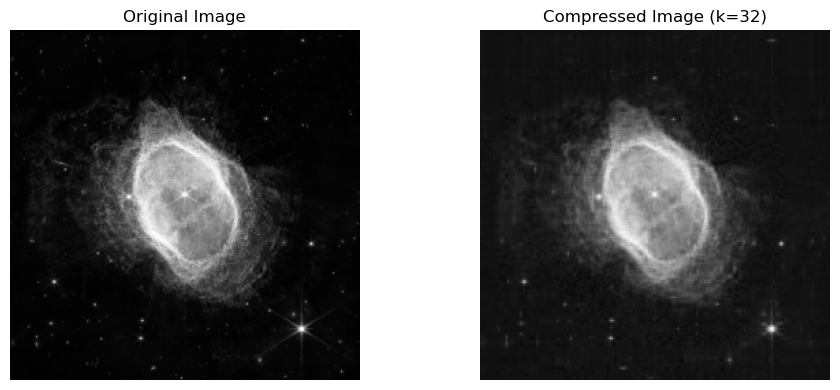

In [40]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Compressed Image (k={optimal_k})")
plt.imshow(compressed_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


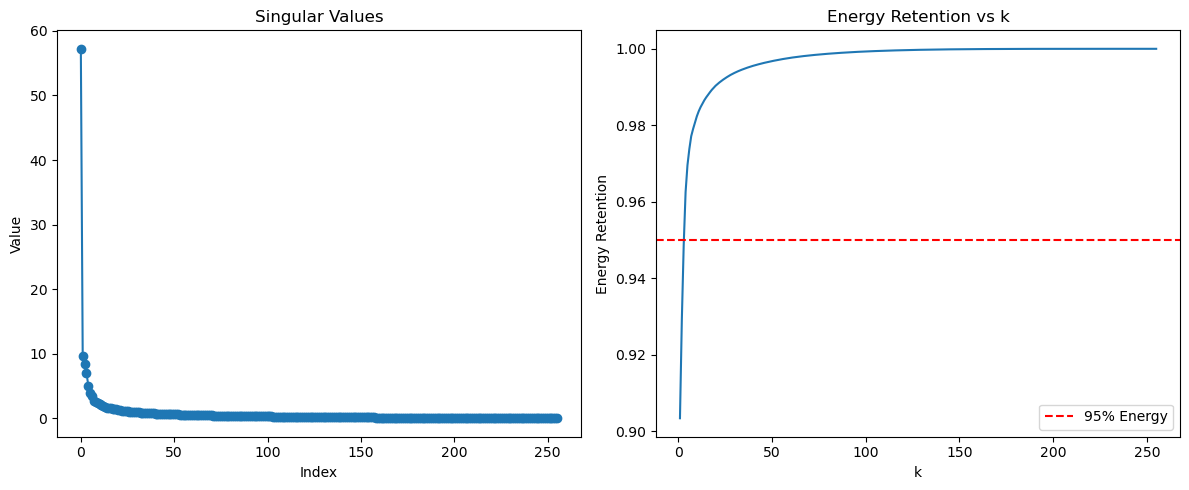

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(S, marker='o')
plt.title("Singular Values")
plt.xlabel("Index")
plt.ylabel("Value")

plt.subplot(1, 2, 2)
energy_vals = [energy_retention(S, k) for k in range(1, len(S))]
plt.plot(range(1, len(S)), energy_vals)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Energy')
plt.title("Energy Retention vs k")
plt.xlabel("k")
plt.ylabel("Energy Retention")
plt.legend()

plt.tight_layout()
plt.show()
